In [17]:
import sys
sys.path.append('..')

import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
import torch.nn.functional as F
from lib.CustomDataset import TimeSeriesHDF5Dataset
from torch.utils.data import DataLoader
from lib.VAE import VAE
from lib.Utilities import *
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import os

torch.manual_seed(10)
############### SCRIPT VARIABLES #######################
segment_length_sec = config['segment_length_sec']
sampling_rate = config['sampling_rate']
overlap = config['overlap']

# lr = 1e-3
# epochs = 50
batch_size=64
percentile_threshold = 95
epsilon = 1e-8

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
best_model_path = '../models/deep_clean_abp_best.pt'
directory_path = '/storage/ms5267@drexel.edu/precicecap_downloads/'
mode = ['ABP','ART']

percentile_threshold_list = [10,20,30,40,50,60,70,80,90,95,99]


def recon_loss(x_orig, x_recon):
    MSELoss = torch.nn.MSELoss(reduction='none')
    
    # Compute the element-wise MSE loss
    mse = MSELoss(x_orig, x_recon)
    
    # # Sum over the features dimension to get the loss for each instance in the batch
    mse_per_instance = mse.mean(dim=1).mean(dim=1)
    
    # # Compute the logarithm of the MSE for each instance
    # log_MSE_per_instance = torch.log(mse_per_instance + 1e-8).squeeze()
    
    return mse_per_instance


def get_threshold(vae, train_files, percentile_threshold=90):
	"""Calculates threshold for anomaly detection

	Args:
		vae (VAE): trained VAE model
		train_files (list): list of training files
		percentile_threshold (int, optional): threshold percentile. Defaults to 90.

	Returns:
		float: calculated threshold
	"""
	recon_loss_arr = []

	log_info(f'Calculating threshold for anomaly detection at percentile: {percentile_threshold}')
	mean = torch.load(f'{config["stored_mean_abp"]}_{segment_length_sec}sec')
	std = torch.load(f'{config["stored_std_abp"]}_{segment_length_sec}sec')

	with torch.no_grad():
		for filename in train_files:
			
			datafile = os.path.join(directory_path, filename)

			for m in mode:
				log_info(f"Processing {filename} Mode: {m}")
				# tqdm_loader = tqdm(train_loader, desc='Training Batch', unit='batch')
				dataset  = TimeSeriesHDF5Dataset(datafile, m, segment_length_sec, overlap, phase="train")    
				
				if len(dataset)!=0:
					dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4,shuffle=True, pin_memory=True)

					for _, data, label, ts in dataloader:
						# Filters only the good segments
						filter = filter_abp_batch(data, label)
						data = data.unsqueeze(1).float().to(device)[filter]
						if len(data)>0:
							data = (data - mean)/std
							recon_batch, z_mean, z_log_var = vae(data)
							
							loss_val = recon_loss(data, recon_batch).cpu().numpy()
							
							# Appending loss to analyze
							recon_loss_arr.extend(loss_val)

	# threshold = np.percentile(recon_loss_arr, percentile_threshold)

	return recon_loss_arr


In [18]:
import matplotlib.pyplot as plt

def plot_data_and_reconstruction(data, recon_batch, sample_index=0):
    """
    Plots the actual data and the reconstructed data from the VAE.

    Parameters:
    data (torch.Tensor): The original data.
    recon_batch (torch.Tensor): The reconstructed data from the VAE.
    sample_index (int): The index of the sample to plot. Default is 0.
    """
    # Extract the first sample from each array
    actual_data = data
    reconstructed_data = recon_batch
    
    # Create a figure and axis
    plt.figure(figsize=(10, 5))
    
    # Plot actual data
    plt.plot(actual_data, color='blue', label='Actual Data')
    
    # Plot reconstructed data
    plt.plot(reconstructed_data, color='red', linestyle='dashed', label='Reconstructed Data')
    
    # Add title and labels
    plt.title('Actual Data vs Reconstructed Data')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.show()


import datetime
import pytz
# Assume abp_timestamp and idx are defined, here's how you convert a timestamp to UTC

def print_time_from_ts(ts):
	utc_time = datetime.datetime.fromtimestamp(int(ts)/1e6, tz=pytz.utc)

	# Now convert UTC time to Eastern Standard Time (EST)
	eastern = pytz.timezone('US/Eastern')
	est_time = utc_time.astimezone(eastern)

	# Print both times to see the result
	print("UTC Time:", utc_time)
	print("Eastern Time:", est_time)

In [19]:
train_files = [
				'34_Patient_2023-04-04_22:31.h5'
				, '73_Patient_2017_Dec_18__11_19_55_297272.h5'
				, '74_Patient_2023-08-05_06:00.h5'
				, '85_Patient_2023-05-12_17:53.h5'
				]

# test_file = '85_Patient_2023-05-12_17:53.h5'
test_file = '90_Patient_2023-03-21_12:19.h5'

vae = torch.load(best_model_path)

vae.eval()

test_mseloss_arr, truth_label = [], []
data_archive, recon_archive, ts_archive = [],[],[]

datafile = os.path.join(directory_path, test_file)

for m in mode:
	dataset  = TimeSeriesHDF5Dataset(datafile, m, segment_length_sec, overlap, phase="test")

	if len(dataset)!=0:    
		dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4,shuffle=False, pin_memory=True)
		
		mean = torch.load(f'{config["stored_mean_abp"]}_{segment_length_sec}sec')
		std = torch.load(f'{config["stored_std_abp"]}_{segment_length_sec}sec')

		with torch.no_grad():
			for _, data, label, ts in tqdm(dataloader):
				data = data.unsqueeze(1).float().to(device)
				
				data = (data-mean)/std
				# print(data.shape)
				recon_batch, z_mean, z_log_var = vae(data)

				data_archive.extend(data.squeeze().tolist())
				recon_archive.extend(recon_batch.squeeze().tolist())
				ts_archive.extend(ts.squeeze().tolist())
				
				# mseloss_val = mseloss(recon_batch, data)

				# mseloss_per_instance = mseloss_val.mean(dim=2).cpu().numpy()
				loss_val = recon_loss(data, recon_batch).cpu().numpy()

				# log_mse = torch.log(mseloss_per_instance + epsilon).cpu().numpy()
				
				# Append MSE loss for each instance to the list
				test_mseloss_arr.extend(loss_val)
				truth_label.extend(label.cpu().numpy())

# mseloss_arr = get_threshold(vae, train_files)


100%|██████████| 72/72 [00:02<00:00, 25.71it/s]

15:23:25 :	  No Waveforms/ART_na in the hdf5 file: <HDF5 file "90_Patient_2023-03-21_12:19.h5" (mode r)>. 



In [20]:
mseloss_arr = get_threshold(vae, train_files)

15:23:25 :	  Calculating threshold for anomaly detection at percentile: 90 

15:23:25 :	  Processing 34_Patient_2023-04-04_22:31.h5 Mode: ABP 

15:23:26 :	  Processing 34_Patient_2023-04-04_22:31.h5 Mode: ART 

15:23:33 :	  Processing 73_Patient_2017_Dec_18__11_19_55_297272.h5 Mode: ABP 

15:23:37 :	  Processing 73_Patient_2017_Dec_18__11_19_55_297272.h5 Mode: ART 

15:23:37 :	  No Waveforms/ART_na in the hdf5 file: <HDF5 file "73_Patient_2017_Dec_18__11_19_55_297272.h5" (mode r)>. 

15:23:37 :	  Processing 74_Patient_2023-08-05_06:00.h5 Mode: ABP 

15:23:54 :	  Processing 74_Patient_2023-08-05_06:00.h5 Mode: ART 

15:23:54 :	  No Waveforms/ART_na in the hdf5 file: <HDF5 file "74_Patient_2023-08-05_06:00.h5" (mode r)>. 

15:23:54 :	  Processing 85_Patient_2023-05-12_17:53.h5 Mode: ABP 

15:24:35 :	  Processing 85_Patient_2023-05-12_17:53.h5 Mode: ART 

15:24:35 :	  No Waveforms/ART_na in the hdf5 file: <HDF5 file "85_Patient_2023-05-12_17:53.h5" (mode r)>. 



In [21]:
np.mean(np.array(mseloss_arr))

0.3261685

In [22]:
percentile_threshold_list= [10,12,13,13.5,14,15,17,20,30,40,50,60,70,72,73,75,76,78, 80,90,95,99,99.9]

for percentile_threshold in percentile_threshold_list:
	threshold = np.percentile(mseloss_arr, percentile_threshold)

	log_info(f'Thresholding at {threshold} for percentile: {percentile_threshold}')

	pred_label = [0 if i < threshold else 1 for i in test_mseloss_arr]

	log_info(f"Accuracy:{accuracy_score(pred_label, truth_label)}")
	log_info(f"F1: {f1_score(pred_label, truth_label)}")
	print(confusion_matrix(truth_label, pred_label))

	accuracy_score(pred_label, truth_label), f1_score(pred_label, truth_label), confusion_matrix(truth_label, pred_label), precision_score(truth_label, pred_label), recall_score(truth_label, pred_label)

15:24:35 :	  Thresholding at 0.1473370373249054 for percentile: 10 

15:24:35 :	  Accuracy:0.05931094635848234 

15:24:35 :	  F1: 0.11051546391752577 

[[   4 4277]
 [  37  268]]
15:24:35 :	  Thresholding at 0.15815097212791443 for percentile: 12 

15:24:35 :	  Accuracy:0.05887483645878761 

15:24:35 :	  F1: 0.10900082576383155 

[[   6 4275]
 [  41  264]]
15:24:35 :	  Thresholding at 0.16337765991687775 for percentile: 13 

15:24:35 :	  Accuracy:0.05800261665939817 

15:24:35 :	  F1: 0.10743801652892562 

[[   6 4275]
 [  45  260]]
15:24:35 :	  Thresholding at 0.1661732551455498 for percentile: 13.5 

15:24:35 :	  Accuracy:0.05800261665939817 

15:24:35 :	  F1: 0.10743801652892562 

[[   6 4275]
 [  45  260]]
15:24:35 :	  Thresholding at 0.16908060908317568 for percentile: 14 

15:24:35 :	  Accuracy:0.05734845180985609 

15:24:35 :	  F1: 0.10626421335538556 

[[   6 4275]
 [  48  257]]
15:24:35 :	  Thresholding at 0.17427944839000703 for percentile: 15 

15:24:35 :	  Accuracy:0.057348

In [23]:
import random


while True:
	idx = random.randint(0, len(pred_label)-1)
	
	if pred_label[idx] == 0 and truth_label[idx] ==0:
		break
	
idx, truth_label[idx], pred_label[idx]

(3612, 0, 0)

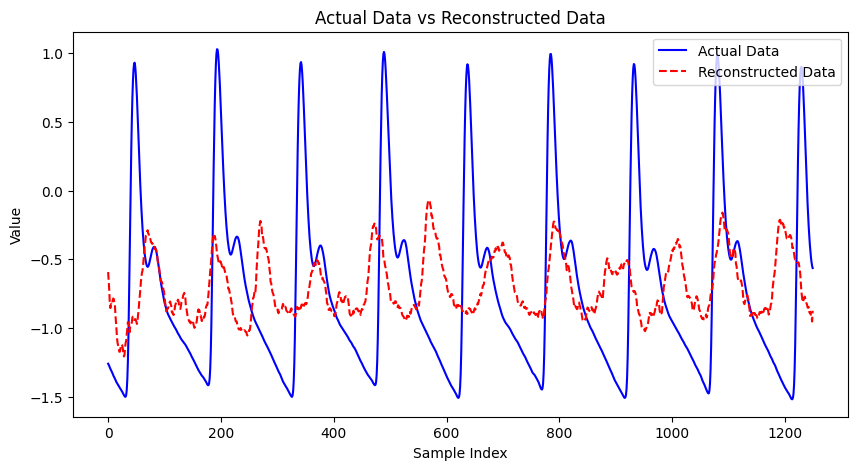

3612 0 0 0.42262098
UTC Time: 2023-03-21 18:41:25.456269+00:00
Eastern Time: 2023-03-21 14:41:25.456269-04:00


In [24]:
plot_data_and_reconstruction(data_archive[idx], recon_archive[idx], sample_index=0)
print(idx, truth_label[idx],  pred_label[idx], test_mseloss_arr[idx])
print_time_from_ts(ts_archive[idx][0])

In [25]:
mseloss = torch.nn.MSELoss(reduction = 'none')

print("Log of MSE", torch.log(torch.mean(mseloss(torch.tensor(data_archive[idx]), torch.tensor(recon_archive[idx])))))
print("MSE", torch.mean(mseloss(torch.tensor(data_archive[idx]), torch.tensor(recon_archive[idx]))))


Log of MSE tensor(-0.8613)
MSE tensor(0.4226)
